# BoomBikes  prediction of demand

#### This assignment is a programming assignment wherein you have to build a multiple linear regression model for the prediction of demand for shared bikes. You will need to submit a Jupyter notebook for the same. 

In [460]:
# For this we will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [461]:
#Importing data
raw_data = pd.read_csv('./data/bik_sharing_dataset.csv')
raw_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.11,18.18,80.58,10.75,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.90,17.69,69.61,16.65,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.05,9.47,43.73,16.64,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.20,10.61,59.04,10.74,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.31,11.46,43.70,12.52,82,1518,1600


## Preprocessing

### Exploring the descriptive statistics of the variables

In [462]:
raw_data.describe(include='all')

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.00,730,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00,730.00
unique,NaN,730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,01-01-2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,365.50,NaN,2.50,0.50,6.53,0.03,3.00,0.68,1.39,20.32,23.73,62.77,12.76,849.25,3658.76,4508.01
std,210.88,NaN,1.11,0.50,3.45,0.17,2.01,0.47,0.54,7.51,8.15,14.24,5.20,686.48,1559.76,1936.01
min,1.00,NaN,1.00,0.00,1.00,0.00,0.00,0.00,1.00,2.42,3.95,0.00,1.50,2.00,20.00,22.00
25%,183.25,NaN,2.00,0.00,4.00,0.00,1.00,0.00,1.00,13.81,16.89,52.00,9.04,316.25,2502.25,3169.75
50%,365.50,NaN,3.00,0.50,7.00,0.00,3.00,1.00,1.00,20.47,24.37,62.62,12.13,717.00,3664.50,4548.50
75%,547.75,NaN,3.00,1.00,10.00,0.00,5.00,1.00,2.00,26.88,30.45,72.99,15.63,1096.50,4783.25,5966.00


### Dealing with missing values

In [463]:
raw_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

##### Looks like there is no null data good for us ! ;)

### Checking for Outliers

<AxesSubplot: xlabel='cnt'>

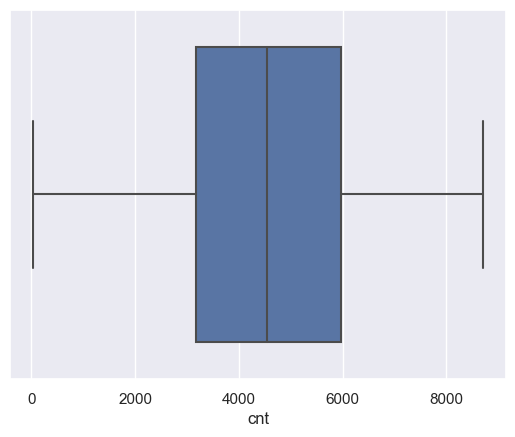

In [464]:
sns.boxplot(x=raw_data['cnt'])

##### No Outliers found we can process data without removing any data

##### If we had any outliers we can use below code to remove them

```
high_cnt = raw_data['cnt'].quantile(0.99)
high_cnt
raw_data_v1 = raw_data[raw_data['cnt']<high_cnt]
raw_data_v1.describe(include='all')
```

### Exploring the PDFs


Finding the distributions

<AxesSubplot: xlabel='cnt', ylabel='Density'>

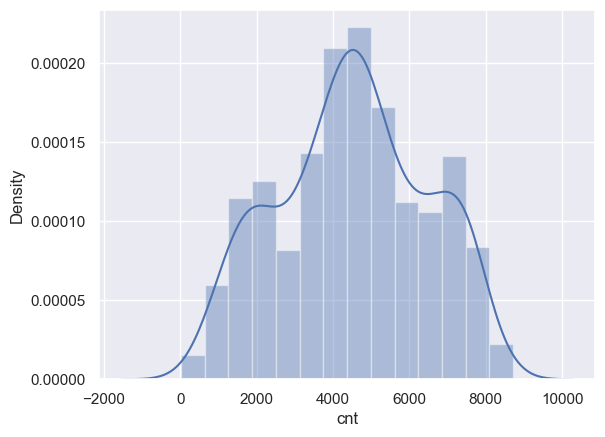

In [465]:
sns.distplot(raw_data['cnt'])

In [466]:
data_cleaned=raw_data
log_cnt = np.log(data_cleaned['cnt'])

data_cleaned['log_cnt'] = log_cnt


<AxesSubplot: xlabel='log_cnt', ylabel='Density'>

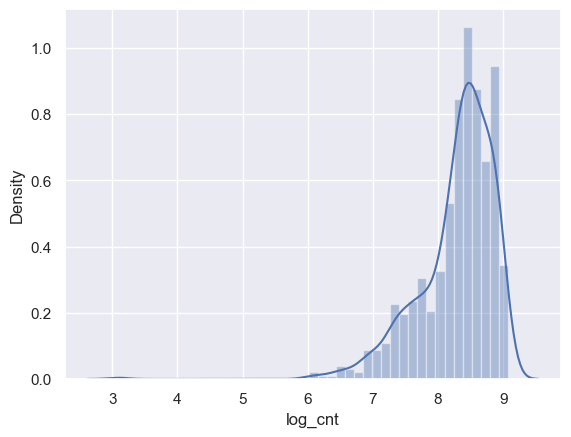

In [467]:
sns.distplot(data_cleaned['log_cnt'])

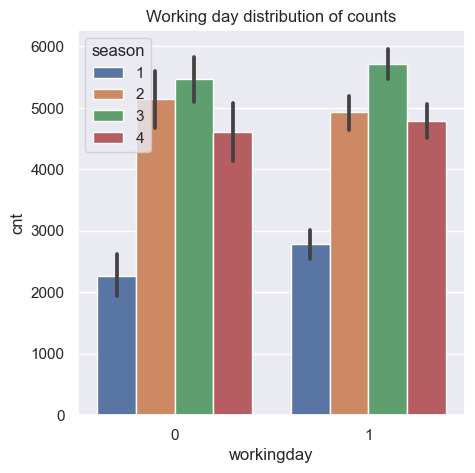

In [468]:
fig,ax=plt.subplots(figsize=(5,5))
sns.barplot(x='workingday',y='cnt',data=data_cleaned,hue='season')
ax.set_title('Working day distribution of counts')
plt.show()



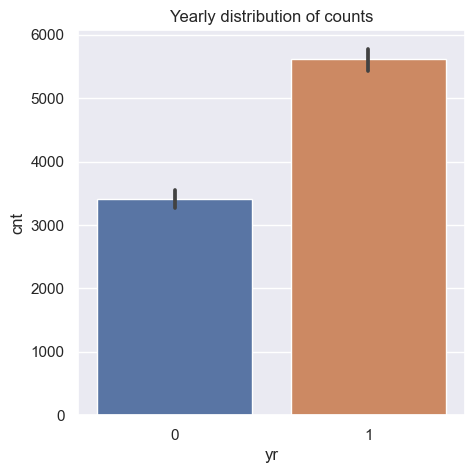

In [469]:
fig,ax=plt.subplots(figsize=(5,5))
sns.barplot(x='yr',y='cnt',data=data_cleaned[['yr','cnt']])
ax.set_title('Yearly distribution of counts')
plt.show()



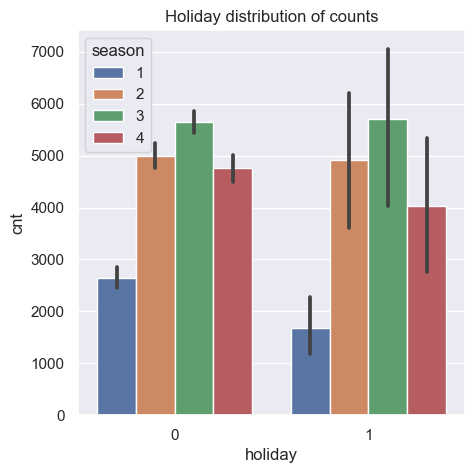

In [470]:
fig,ax=plt.subplots(figsize=(5,5))
sns.barplot(x='holiday',y='cnt',data=data_cleaned,hue='season')
ax.set_title('Holiday distribution of counts')
plt.show()





In [471]:
### Relaxing the assumptions


log_cnt = np.log(data_cleaned['cnt'])
data_cleaned['log_cnt'] = log_cnt

log_temp = np.log(data_cleaned['temp'])
data_cleaned['log_temp'] = log_temp


log_hum = np.log(data_cleaned['hum'])
data_cleaned['log_hum'] = log_hum

# Calculating VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_cleaned[['workingday','log_temp','weekday','season']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif


,VIF,features
0,3.11,workingday
1,11.19,log_temp
2,3.11,weekday
3,7.06,season


Holiday, Season , weather are much correlated with the demand.

In [472]:
#Rename the columns
data_for_training=data_cleaned
data_for_training.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

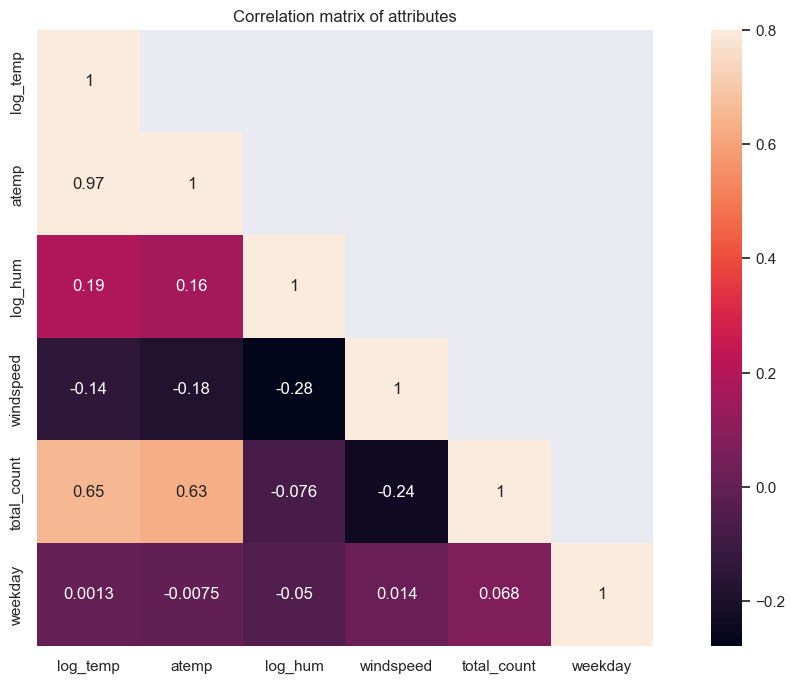

In [473]:
#Create the correlation matrix
correMtr=data_cleaned[["log_temp","atemp","log_hum","windspeed","total_count","weekday"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

1. Season
2. Month
3. Year
4. Temp/LogTemp
5. Wind Speed 

These independednt variabls are key for predection

### Model

In [474]:
# Distributing train data and testing data

from sklearn.model_selection import train_test_split
targets = data_for_training['log_cnt']
data_with_corelation = data_for_training[['season','month','year','weekday','holiday','workingday','weather_condition','humidity','log_temp','windspeed']]
x_train, x_test, y_train, y_test = train_test_split(data_with_corelation, targets, test_size=0.2, random_state=365)

In [475]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression()

In [476]:
# Measuring y hat

y_hat = reg.predict(x_train)

Text(0.5, 1.0, 'Residuals PDF')

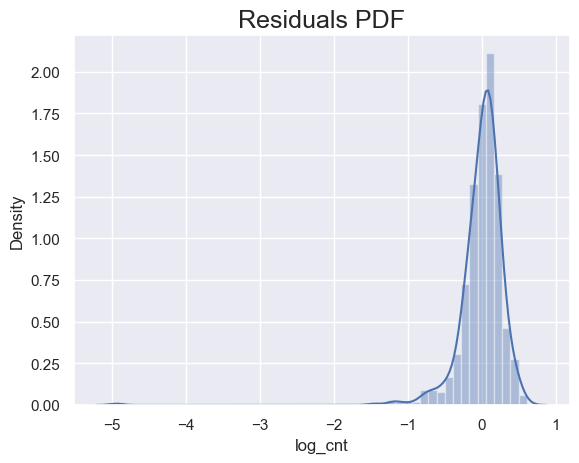

In [477]:
# Visualizing Residual

sns.distplot(y_train - y_hat)
plt.title("Residuals PDF", size=18)

In [478]:
reg.score(x_train,y_train)

0.6951959123604061

In [479]:
reg.coef_

array([ 0.15974735, -0.02081022,  0.46172671,  0.01750276, -0.10196864,
        0.04549816, -0.21674267, -0.00373743,  0.68564225, -0.0148165 ])

In [480]:
reg_summary = pd.DataFrame(data_with_corelation.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,season,0.16
1,month,-0.02
2,year,0.46
3,weekday,0.02
4,holiday,-0.10
5,workingday,0.05
6,weather_condition,-0.22
7,humidity,-0.00
8,log_temp,0.69
9,windspeed,-0.01


In [481]:
y_hat_test = reg.predict(x_test)

### Wow The predection is linear as the model is good at predecting the target

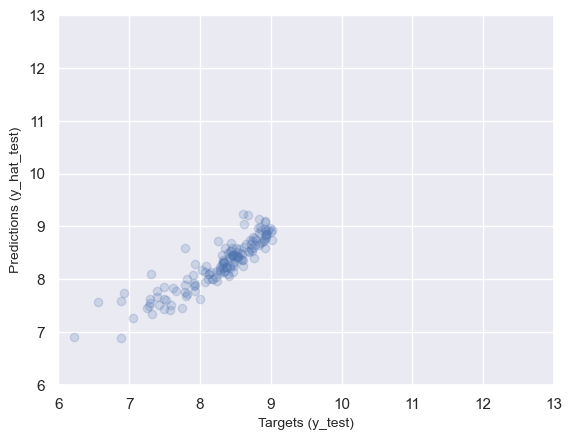

In [482]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=10)
plt.ylabel('Predictions (y_hat_test)',size=10)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [483]:
y_test = y_test.reset_index(drop=True)
y_test.head()

0   8.74
1   7.06
2   7.59
3   8.01
4   7.32
Name: log_cnt, dtype: float64

In [457]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,5063.54,6230.00
1,1429.67,1162.00
2,1825.41,1977.00
3,2061.42,2999.00
4,1547.75,1510.00
5,6007.42,7132.00
6,4994.81,5062.00
7,5134.90,5875.00
8,8546.81,5531.00
9,2974.45,3613.00


### Predection and test data diffrence

In [458]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,5063.54,6230.00,1166.46,18.72
1,1429.67,1162.00,-267.67,23.04
2,1825.41,1977.00,151.59,7.67
3,2061.42,2999.00,937.58,31.26
4,1547.75,1510.00,-37.75,2.50
5,6007.42,7132.00,1124.58,15.77
6,4994.81,5062.00,67.19,1.33
7,5134.90,5875.00,740.10,12.60
8,8546.81,5531.00,-3015.81,54.53
9,2974.45,3613.00,638.55,17.67


In [459]:

pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
68,4166.00,4169.00,3.00,0.07
72,4710.41,4725.00,14.59,0.31
17,6567.30,6536.00,-31.30,0.48
23,979.18,986.00,6.82,0.69
67,4090.46,4120.00,29.54,0.72
28,4747.60,4713.00,-34.60,0.73
142,7925.36,8009.00,83.64,1.04
25,5494.65,5557.00,62.35,1.12
118,4104.76,4153.00,48.24,1.16
6,4994.81,5062.00,67.19,1.33
